This part of code is advanced model implementation on the protein function prediction using multi-label classification

In [ ]:
!pip install category_encoders
!pip install Bio
!pip install transformers
!pip install tensorflow_addons
!pip install dgl

In [ ]:
import pandas as pd
import numpy as np
import dgl
from dgl.nn import GraphConv
import torch.nn as nn
import torch.optim as optim
import requests
import tensorflow as tf
import torch
import itertools
from keras.wrappers.scikit_learn import BaseWrapper
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from category_encoders import BinaryEncoder
from gensim.models import Word2Vec
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.callbacks import EarlyStopping
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from itertools import combinations
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from keras.models import Sequential, Model
from keras.layers import Reshape, TimeDistributed, Embedding, LSTM, Dense, Dropout, Bidirectional, InputLayer, Flatten, Conv2D, MaxPooling2D, Input, Attention, Conv1D, MaxPooling1D, Flatten, concatenate
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from keras.regularizers import l1, l2
from keras.optimizers import Adam
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report, jaccard_score, accuracy_score, precision_score, recall_score, f1_score, hamming_loss, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import StackingClassifier, GradientBoostingClassifier
from tensorflow.keras.optimizers import Adam
from transformers import pipeline, AutoTokenizer, TFAutoModelForSequenceClassification, TFAutoModel
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.base import BaseEstimator, TransformerMixin
import tensorflow_addons as tfa
from tensorflow.keras.layers import  BatchNormalization, LayerNormalization, MultiHeadAttention, Dense, Dropout
from transformers import TransfoXLModel, XLNetModel
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertModel,TransfoXLConfig
from keras import backend as K
from tensorflow.keras.losses import binary_crossentropy
from keras.layers import Input, Dense, Embedding, LSTM, Bidirectional, Dropout, TimeDistributed, Lambda, Activation, Concatenate

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# Read the data

Data is implemented in Data_integraton.ipynb. 

The raw data has 386735 protein sequences. 
https://www.uniprot.org/uniprotkb?query=%2A

 We only keep 100 unique labels, and there are totally 92135 protein sequences after data cleaning. 

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/CIS522_Final_Project/data_cleaned.csv')
data['splitted_go_labels'] = data['splitted_go_labels'].apply(eval)
data['interactors'] = data['interactors'].apply(eval)

# Class imbalance: 

remove a go label from the dataset(see data integration file) to check if removing the protein with this go label will make the predictor variable more balanced

In [ ]:
comparison_go5886 = []
for i in range(data.shape[0]):
   result = (data.splitted_go_labels[i] == ['GO:0005886'])
   comparison_go5886.append(result)

true_indices = np.where(comparison_go5886)[0]
#data = data.drop(true_indices, axis=0).reset_index(drop=True)

# Data Processsing

## Go labels

convert the go labels of each protein sequence to binary vector. There are total 100 unique go labels for all the sequences in our data.

In [ ]:
# Convert GO labels into binary vectors
mlb = MultiLabelBinarizer()
binary_labels = mlb.fit_transform(data["splitted_go_labels"])

In [ ]:
binary_labels

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

## Interactor

We have 75 unique interactors. The reason to select binary encoding is that it uses fewer binary columns to represent the same information. A value of 1 indicates that the interactor is present for a given sequence, and 0 indicates its absence. 

In [ ]:
for i in range(data.shape[0]):
    if data['interactors'][i] == ['NaN']:
       data.at[i, 'interactors'] = ['']

In [ ]:
encoder = BinaryEncoder()
interactor_id_encoded = encoder.fit_transform(data['interactors'].apply(pd.Series))

In [ ]:
interactor_id_encoded_arr = np.array(interactor_id_encoded)

In [ ]:
interactor_id_encoded_arr.shape

(92135, 75)

## Protein sequence

Drop some amino acid that are not useful that may impact our prediction analysis so that we only keep 21 amino acid and use them to expand out feature set

In [ ]:
data['sequence'] = data['sequence'].str.replace('X', '')
data['sequence'] = data['sequence'].str.replace('U', '')
data['sequence'] = data['sequence'].str.replace('B', '')
data['sequence'] = data['sequence'].str.replace('Z', '')

This part of code consturcts the embedding of protein sequences using the word2Vec and then combines it with the one-hot encoding. However, during the later training process, embedding doesn't seem to improve the accuaracy or F1 score too much.

In [ ]:
#tokens = [list(sequence) for sequence in data.sequence]
#flat_tokens = [word for sublist in tokens for word in sublist]
#word2vec_model = Word2Vec(tokens, size=100, window=5, min_count=1, sg=1)  # Use Skip-gram (sg=1)
#encoded_tokens = [word2vec_model.wv[word] for word in flat_tokens if word in word2vec_model.wv.vocab]
#np.array(encoded_tokens)
#one_hot_encoder = OneHotEncoder()
#protein_sequences_2d = np.array(data.sequence).reshape(-1, 1)
#one_hot_encoded_seq = one_hot_encoder.fit_transform(protein_sequences_2d).toarray()

### Motif Base K-mer counting(Innovation)

Instead of one-hot encoding (the common stratgies in protein predictions papers), I use the k-mer counting. In this approach, k-mers, which are subsequences of length k from the protein sequences, are used as features. The frequency of each k-mer is calculated, and the resulting frequency vector can be used as a feature representation. This approach captures local sequence information and can be useful for certain types of protein sequence analysis.

**Advantage:**\
K-mer counting can result in a compact and fixed-dimensional feature representation.It captures local sequence information, as it considers short contiguous subsequences in the sequence, which is important for capturing local patterns or motifs that are relevant for the task at hand, such as protein functional annotations or DNA sequence motifs. It can provide insights into the presence or absence of certain sequence motifs or patterns that may be biologically relevant and aid in the interpretation of the machine learning models' predictions.

In [ ]:
vectorizer = CountVectorizer(analyzer='char', ngram_range=(2, 2))

# Fit and transform the protein sequences
X_kmer = vectorizer.fit_transform(data.sequence)

# Convert the sparse matrix to a dense numpy array
X_kmer = X_kmer.toarray()

I also count the occurrence of motif bases. 

Glycine (Gly) motif: 'GGG',
Alanine (Ala) motif: 'GCA',
Leucine (Leu) motif: 'CTA'\
Serine (Ser) motif: 'TCA',
Proline (Pro) motif: 'CCA'\
Phenylalanine (Phe) motif: 'TTC',
Tyrosine (Tyr) motif: 'TAC'\
Histidine (His) motif: 'CAC',
Aspartic acid (Asp) motif: 'GAC',
Glutamic acid (Glu) motif: 'GAA'\

These motif bases or any other specific motif bases that are relevant to protein function prediction task to count their occurrences in protein sequences

In [ ]:
motif_bases = ['AGAGA', 'AGAGT', 'AGAGG', 'AGAGC', 'AGACA', 'AGACT', 'AGACG', 'AGACC', 'AGTAA', 'AGTAT', 
               'AGTAG', 'AGTAC', 'AGTTA', 'AGTTT', 'AGTTG', 'AGTTC', 'AGTGA', 'AGTGT', 'GGG', 'GCA', 'CTA', 
               'TCA', 'CCA', 'TTC', 'TAC', 'CAC', 'GAC', 'GAA', 'AATA', 'AATG', 'AGAA', 'AGAC', 'ATCA', 'ATCG', 
               'ATTA', 'ATTC', 'TAAA', 'TAAG', 'TATG', 'TCAA', 'TCAG', 'TCCA', 'TCCG', 'TCTA', 'TCTC', 'TCTG', 
               'TGAA', 'TGAC', 'TGAG', 'TGCA', 'TGCG', 'TGTA', 'TGTG', 'TTAA', 'TTAG', 'TTCA', 'TTCC', 'TTCG', 
               'TTGA', 'TTGC', 'TTGG', 'TCAA', 'TCCC', 'TCTA', 'TGCC', 'TGCT', 'TGGA', 'TTAG', 'TTAT', 'TTCC', 
               'TTCT', 'TTGA', 'TTGC', 'TTGG', 'AACG', 'AAGG', 'ACGG', 'AGGG', 'ATGG', 'CAAG', 'CAGG', 'CCAG', 
               'CCGG', 'CGAG', 'CGGG', 'CTAG', 'CTGG', 'GAAG', 'GAGG', 'GCAG', 'GCGG', 'GGAG', 'GGGG', 'GTAG', 
               'GTGG', 'TAAG', 'TAGG', 'TCAG', 'TCCG', 'TTAG']


In [ ]:
motif_df = pd.DataFrame(columns=motif_bases)

# Iterate through motif bases and count occurrences in each sequence
for motif in motif_bases:
    motif_df[motif] = data['sequence'].str.count(motif)

In [ ]:
motif_array = motif_df.values

### Physicochemical properties

Calculate the physicochemical properties of each amino acid in a protein sequence

I also define a function to calculate the association rules between pairs of physicochemical properties

In [ ]:
def get_physicochemical_features(seq):
    protein = ProteinAnalysis(seq)
    mol_weight = protein.molecular_weight()
    aromaticity = protein.aromaticity()
    instability_index = protein.instability_index()
    isoelectric_point = protein.isoelectric_point()
    gravy = protein.gravy()
    return [mol_weight, aromaticity, instability_index, isoelectric_point, gravy]

def get_association_rules(features, min_support=0.2, min_threshold=0.5):
    # Convert continuous values to binary values based on threshold
    threshold = 0 # Set threshold for gravy
    features_binary = [True if x >= threshold else False for x in features]
    df = pd.DataFrame([features_binary], columns=['mol_weight', 'aromaticity', 'instability_index', 'isoelectric_point', 'gravy'])
    frequent_items = apriori(df, min_support=min_support, use_colnames=True)
    rules = association_rules(frequent_items, metric='confidence', min_threshold=min_threshold)
    return rules[['antecedents', 'consequents']]

1. Physicochemical properties of proteins, including molecular weight, aromaticity, instability index, isoelectric point, and gravy, provide a quantitative characterization of protein sequences. These properties can capture important structural and functional characteristics of proteins that are relevant to their biological functions, including protein-protein interactions, cellular localization, and enzymatic activities. 

2. Pysicochemical properties are general features that can be computed for any protein sequence, regardless of its species or domain of life. This makes them transferable across different organisms and can be used to predict GO labels for proteins from diverse species, even if limited annotated data are available for those species

Hansen, K., Biegler, F., Ramakrishnan, R., Pronobis, W., Von Lilienfeld, O. A., Muller, K. R., & Tkatchenko, A. (2015). Machine learning predictions of molecular properties: Accurate many-body potentials and nonlocality in chemical space. The journal of physical chemistry letters, 6(12), 2326-2331.

### Association Rules(Innovation)

Association rules can help identify relevant combinations of physicochemical properties that are strongly associated with a particular outcome or target variable, such as the prediction of protein function or Gene Ontology (GO) labels.

Association rules can also be used to augment the feature space by identifying and incorporating additional physicochemical properties that are associated with the features of interest.

Incorporating association rules with physicochemical properties as features in deep learning models can potentially improve their performance by capturing higher-order interactions and non-linear relationships among the features, which may not be captured by individual properties alone.


In [ ]:
# Define the physicochemical properties and association rule thresholds
physicochemical_properties = ['mol_weight', 'aromaticity', 'instability_index', 'isoelectric_point', 'gravy']
min_support = 0.2
min_threshold = 0.5

# Calculate the physicochemical properties and generate the expanded features
expanded_features = []

for i, seq in enumerate(data.sequence):  # Move the i variable initialization outside the loop
    features = get_physicochemical_features(seq)
    unique_pairs = set()  # Create a set to collect unique pairs

    rules = get_association_rules(features, min_support=min_support, min_threshold=min_threshold)
    antecedents_set = set(map(frozenset, rules['antecedents']))

    for pair in combinations(features, 2):
        if frozenset(pair) in antecedents_set:  # Check for membership in the set
            unique_pairs.add(pair)  # Add unique pairs to the set

    features.extend(unique_pairs)  # Extend the features list with unique pairs
    expanded_features.append(features)

    if (i + 1) % 5000 == 0:
        print('Finished processing', i + 1, 'sequences')

Finished processing 5000 sequences
Finished processing 10000 sequences
Finished processing 15000 sequences
Finished processing 20000 sequences
Finished processing 25000 sequences
Finished processing 30000 sequences
Finished processing 35000 sequences
Finished processing 40000 sequences
Finished processing 45000 sequences
Finished processing 50000 sequences
Finished processing 55000 sequences
Finished processing 60000 sequences
Finished processing 65000 sequences
Finished processing 70000 sequences
Finished processing 75000 sequences
Finished processing 80000 sequences
Finished processing 85000 sequences
Finished processing 90000 sequences


In [ ]:
#expanded_features = pd.DataFrame(expanded_features)
#path = '/content/drive/My Drive/CIS522_Final_Project/expanded_features_new.csv'
#expanded_features.to_csv(path, index=False)

# Feature integration

##Target Variable

Target variable is go labels, and there are 100 unique labels with binary representation

In [ ]:
binary_labels.shape

(92135, 100)

Predictor variables:

## Interactors(protein-protein interaction)

The proteins interacts with the target protein: 75 unique labels with binary representation

In [ ]:
interactor_id_encoded_arr.shape

(92135, 75)

## Protein sequence with K-mer counting

There are total 500 features 

In [ ]:
X_kmer.shape, motif_array.shape

((92135, 400), (92135, 100))

## Physicochemical properties of proteins

Physicochemical properties of proteins including molecular weight, aromaticity, instability index, isoelectric point, and gravy with association as the expanding features, which is computed by the association rule.

In [ ]:
expanded_features = np.array(expanded_features)

## Concatenate all the variables

In [ ]:
X_interactor = interactor_id_encoded_arr
X_km = X_kmer
X_motif = motif_array
X_physicochemical = expanded_features
y = binary_labels

In [ ]:
X_combined = np.hstack((X_interactor, X_km, X_physicochemical, X_motif ))

All these features are fed into the neural network to implement models

There are total 100 columns in y since there are 100 unique features, which is used for multi-label prediction

## Data Normalization



In [ ]:
scaler = MinMaxScaler()
# Normalize the 2D array directly
X_combined_normalized = scaler.fit_transform(X_combined)

# Multi-Label Classification

Min-Max scaler in sklearn package is used to implement data normalization on the training data


## Bidirectional LSTM

In a standard LSTM, the hidden state is computed based on the current input and the previous hidden state, which captures information about the past context. In a bidirectional LSTM, two separate LSTM layers are used, one processing the sequence in the forward direction and the other processing it in the backward direction. The hidden states of both LSTM layers are concatenated to produce the final output. 

bidirectional LSTM also captures  long-range dependencies.where the relevant information may be spread throughout the sequence.  In protein sequences, the position of an amino acid residue can be important for determining its function or role in a biological process. By processing the sequence in both directions, a bidirectional LSTM can capture the dependencies between the residues in the protein sequence, which can improve the accuracy of predicting the corresponding GO labels. Additionally, protein sequences can be long, and bidirectional LSTMs are effective in learning long-term dependencies in the data. 




In [ ]:
X_combined_normalized_3d = np.expand_dims(X_combined_normalized, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_combined_normalized_3d, y, test_size=0.2, random_state=66)

In [ ]:
# Build the LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(128, kernel_regularizer=l1(0.001), recurrent_regularizer=l1(0.001), input_shape=(X_train.shape[1], X_train.shape[2]))))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001)))
model.add(Dense(y_train.shape[1], activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split = 0.1)

Epoch 1/50
900/900 [==============================] - 7s 5ms/step - loss: 0.0674 - accuracy: 0.3222 - val_loss: 0.0445 - val_accuracy: 0.4634
Epoch 2/50
900/900 [==============================] - 4s 5ms/step - loss: 0.0423 - accuracy: 0.4415 - val_loss: 0.0394 - val_accuracy: 0.5041
Epoch 3/50
900/900 [==============================] - 3s 4ms/step - loss: 0.0375 - accuracy: 0.4718 - val_loss: 0.0350 - val_accuracy: 0.5247
Epoch 4/50
900/900 [==============================] - 3s 4ms/step - loss: 0.0332 - accuracy: 0.4952 - val_loss: 0.0315 - val_accuracy: 0.4994
Epoch 5/50
900/900 [==============================] - 4s 5ms/step - loss: 0.0299 - accuracy: 0.5124 - val_loss: 0.0289 - val_accuracy: 0.5478
Epoch 6/50
900/900 [==============================] - 4s 5ms/step - loss: 0.0272 - accuracy: 0.5289 - val_loss: 0.0267 - val_accuracy: 0.5163
Epoch 7/50
900/900 [==============================] - 3s 4ms/step - loss: 0.0251 - accuracy: 0.5399 - val_loss: 0.0251 - val_accuracy: 0.5653
Epoch 

### LSTM result

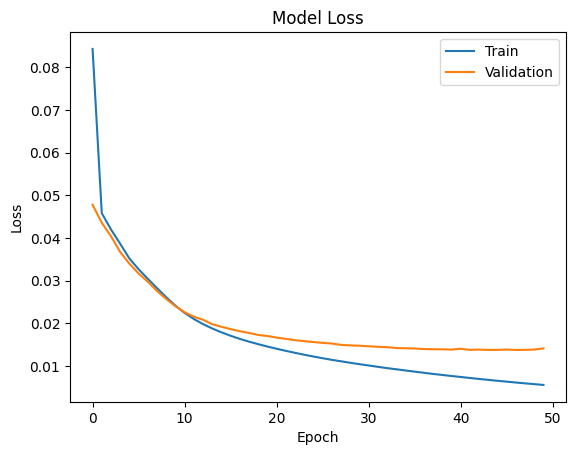

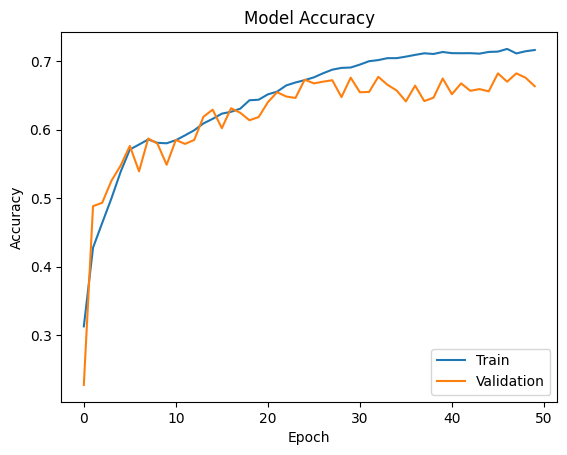

In [ ]:
# Plot the loss curve
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot the training accuracy curve
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [ ]:
# Predict the labels for the validation set
y_pred = model.predict(X_test)

# Convert probabilities to binary labels
y_pred = np.round(y_pred)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

250/250 [==============================] - 2s 8ms/step


In [ ]:
print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"F1-score: {f1*100:.2f}%")

Accuracy: 69.26%
Precision: 79.28%
Recall: 75.9%
F1-score: 79.39%


In [ ]:
n_classes = 100
hamming_loss = (n_classes - accuracy*100 - precision*100 - recall*100 + (2 * f1)) / n_classes
print('Hamming loss is :', hamming_loss)

Hamming loss is : 0.2993


## Attention-based RNN (Bidirectional LSTM)



Network Construction Steps:

1. Add embedding layer that maps the input data to a dense vector space of 32 dimensions
2. Add bidirectional LSTM layer on top of the embedding layer, which processes the input sequence in both forward and backward directions
3. Implement the attention mechanism by applying a TimeDistributed Dense layer with an output size of 1 and a tanh activation function to the LSTM layer output. The result is then squeezed to remove the extra dimension and passed through a softmax activation function to obtain attention weights
4. Expand attention weights to add an extra dimension, which is concatenated with the LSTM layer output to obtain a context vector
5. Apply a dense layer with sigmoid activation function on the output of the dropout layer to predict the output with num_labels = 100 classes.

However, the BLSTM has limitations in handling long sequences, as it treats all input elements equally and may not pay attention to the most relevant elements. Attention mechanism can address this limitation by allowing the model to selectively focus on the most important elements of the input sequence.

An attention mechanism is incorporated into the BLSTM model to improve its performance. Specifically, the attention mechanism calculates a weight for each element in the input sequence based on its relevance to the output prediction. These weights are then used to compute a weighted sum of the BLSTM outputs, which generates a context vector that captures the most important features of the input sequence. Compared to the BLSTM, the attention-based BLSTM can better handle long sequences by focusing on the most relevant elements of the input sequence

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_combined_normalized, y, test_size=0.2, random_state=99)

In [ ]:
input_layer = Input(shape=(580,))
vocab_size = 21
embedding_size = 32
hidden_size = 32
dropout_rate = 0.2
num_labels = 100

embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=580, mask_zero=True)(input_layer)
lstm_layer = Bidirectional(LSTM(units=hidden_size, return_sequences=True))(embedding_layer)
# Add Batch Norm Layer
lstm_layer = BatchNormalization()(lstm_layer)
# Attention mechanism
attention = TimeDistributed(Dense(1, activation='tanh'))(lstm_layer)
attention = Lambda(lambda x: K.squeeze(x, axis=-1))(attention)
attention = Activation('softmax')(attention)
attention = Lambda(lambda x: K.expand_dims(x, axis=-1))(attention)
context_vector = Concatenate(axis=-1)([lstm_layer, attention])
context_vector = Lambda(lambda x: K.sum(x, axis=1))(context_vector)

dropout_layer = Dropout(dropout_rate)(context_vector)
output_layer = Dense(num_labels, activation='sigmoid')(dropout_layer)

In [ ]:
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history = model.fit(X_train, y_train, epochs = 50, batch_size = 32, validation_split=0.1)

Epoch 1/50
900/900 [==============================] - 14s 9ms/step - loss: 0.0412 - accuracy: 0.4365 - val_loss: 0.0261 - val_accuracy: 0.5047
Epoch 2/50
900/900 [==============================] - 6s 7ms/step - loss: 0.0212 - accuracy: 0.5530 - val_loss: 0.0217 - val_accuracy: 0.5334
Epoch 3/50
900/900 [==============================] - 4s 5ms/step - loss: 0.0167 - accuracy: 0.5813 - val_loss: 0.0204 - val_accuracy: 0.5575
Epoch 4/50
900/900 [==============================] - 5s 6ms/step - loss: 0.0138 - accuracy: 0.6060 - val_loss: 0.0197 - val_accuracy: 0.5134
Epoch 5/50
900/900 [==============================] - 5s 6ms/step - loss: 0.0116 - accuracy: 0.6309 - val_loss: 0.0195 - val_accuracy: 0.5562
Epoch 6/50
900/900 [==============================] - 6s 7ms/step - loss: 0.0096 - accuracy: 0.6400 - val_loss: 0.0196 - val_accuracy: 0.6388
Epoch 7/50
900/900 [==============================] - 8s 9ms/step - loss: 0.0081 - accuracy: 0.6536 - val_loss: 0.0208 - val_accuracy: 0.6128
Epoch

### Attention-based LSTM result

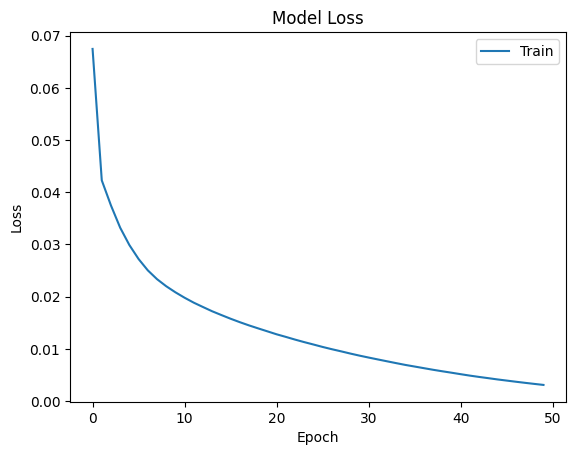

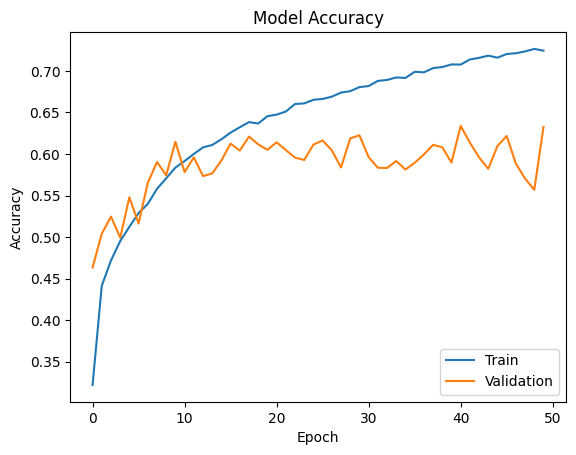

In [ ]:
# Plot the loss curve
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot the training accuracy curve
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [ ]:
# Predict the labels for the validation set
y_pred = model.predict(X_test)

# Convert probabilities to binary labels
y_pred = np.round(y_pred)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

250/250 [==============================] - 1s 3ms/step


In [ ]:
print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"F1-score: {f1*100:.2f}%")

Accuracy: 76.88%
Precision: 86.57%
Recall: 78.69%
F1-score: 83.87%


In [ ]:
n_classes = 100
hamming_loss = (n_classes - accuracy*100 - precision*100 - recall*100 + (2 * f1)) / n_classes
print('Hamming loss is :', hamming_loss)

## GCN (Graph Convolutional Networks)

Graph Convolutional Networks (GCNs are a type of geometric deep learning model that can operate on graph-structured data, such as protein sequences and functions.

GCNs can be used to learn amino acids in protein sequences By leveraging the graph structure, GCNs can capture local and global contextual information, which can be useful for predicting protein sequences based on sequences and functions.

GCN also allows for the incorporation of prior domain knowledge, such as protein structure information into the graph representation. GCN could also handle variable-length protein sequences.

In [ ]:
protein_seq = list(data['sequence'].apply(lambda x: x[:400]))

Here are the steps for implementing GCN

1. Generating dummy data for protein sequences and GO labels
2. Creating a graph representation for the proteins
3. Calculating node features for each protein
4. Construct GCN model with three Graph Convolutional layers

In [ ]:
adjacency_matrix = np.identity(len(data))

#Calculate node features for each protein (using k-mer frequency)
k = 2
kmers = [''.join(x) for x in itertools.product('ACDEFGHIKLMNPQRSTVWY', repeat=k)]
kmer_idx = {kmer: idx for idx, kmer in enumerate(kmers)}

def get_kmer_counts(sequence, k):
    counts = np.zeros(len(kmers))
    for i in range(len(sequence) - k + 1):
        kmer = sequence[i:i + k]
        idx = kmer_idx.get(kmer, -1)
        if idx >= 0:
            counts[idx] += 1
    return counts / sum(counts)

node_features = np.array([get_kmer_counts(seq, k) for seq in protein_seq])

# Normalize node features
scaler = MinMaxScaler()
node_features = scaler.fit_transform(node_features)

In [ ]:
# Build a Graph Convolutional Network model
class GCNModel(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super(GCNModel, self).__init__()
        self.conv1 = GraphConv(in_features, hidden_features)
        self.conv2 = GraphConv(hidden_features, hidden_features)
        self.conv3 = GraphConv(hidden_features, out_features)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, g, inputs):
        h = self.conv1(g, inputs)
        h = self.relu(h)
        h = self.conv2(g, h)
        h = self.relu(h)
        h = self.conv3(g, h)
        h = self.sigmoid(h)
        return h

# Instantiate the GCN model
model = GCNModel(node_features.shape[1], 64, binary_labels.shape[1])

# 5. Train the model
loss_function = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Create DGL graph
g = dgl.graph((np.nonzero(adjacency_matrix)[0], np.nonzero(adjacency_matrix)[1]))
g.ndata['features'] = torch.tensor(node_features, dtype=torch.float32)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(np.arange(len(data)), binary_labels, test_size=0.3, random_state=66)

In [ ]:
# Train GCN model
num_epochs = 150
losses =[]
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    predictions = model(g, g.ndata['features'])
    loss = loss_function(predictions[X_train], torch.tensor(y_train, dtype=torch.float32))
    loss.backward()
    optimizer.step()
    losses.append(loss)
    if epoch % 10 == 0:
       print(f"Epoch: {epoch + 1}, Loss: {loss.item()}")

# Evaluate the model
model.eval()
with torch.no_grad():
    predictions_val = model(g, g.ndata['features'])[X_val]
    y_pred = (predictions_val > 0.5).numpy().astype(int)

/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


Epoch: 1, Loss: 0.693082869052887
Epoch: 11, Loss: 0.10271090269088745
Epoch: 21, Loss: 0.08667021244764328
Epoch: 31, Loss: 0.06168321892619133
Epoch: 41, Loss: 0.05753663182258606
Epoch: 51, Loss: 0.056382838636636734
Epoch: 61, Loss: 0.055215489119291306
Epoch: 71, Loss: 0.053579285740852356
Epoch: 81, Loss: 0.050700075924396515
Epoch: 91, Loss: 0.04801743105053902
Epoch: 101, Loss: 0.04656505212187767
Epoch: 111, Loss: 0.04561074823141098
Epoch: 121, Loss: 0.04486384242773056
Epoch: 131, Loss: 0.04422282800078392
Epoch: 141, Loss: 0.04347911849617958


### GCN result

In [ ]:
losses

[tensor(0.6931, grad_fn=<BinaryCrossEntropyBackward0>),
 tensor(0.6435, grad_fn=<BinaryCrossEntropyBackward0>),
 tensor(0.5497, grad_fn=<BinaryCrossEntropyBackward0>),
 tensor(0.4044, grad_fn=<BinaryCrossEntropyBackward0>),
 tensor(0.2400, grad_fn=<BinaryCrossEntropyBackward0>),
 tensor(0.1226, grad_fn=<BinaryCrossEntropyBackward0>),
 tensor(0.0830, grad_fn=<BinaryCrossEntropyBackward0>),
 tensor(0.0850, grad_fn=<BinaryCrossEntropyBackward0>),
 tensor(0.0934, grad_fn=<BinaryCrossEntropyBackward0>),
 tensor(0.0985, grad_fn=<BinaryCrossEntropyBackward0>),
 tensor(0.1027, grad_fn=<BinaryCrossEntropyBackward0>),
 tensor(0.1070, grad_fn=<BinaryCrossEntropyBackward0>),
 tensor(0.1091, grad_fn=<BinaryCrossEntropyBackward0>),
 tensor(0.1099, grad_fn=<BinaryCrossEntropyBackward0>),
 tensor(0.1080, grad_fn=<BinaryCrossEntropyBackward0>),
 tensor(0.1045, grad_fn=<BinaryCrossEntropyBackward0>),
 tensor(0.1023, grad_fn=<BinaryCrossEntropyBackward0>),
 tensor(0.1002, grad_fn=<BinaryCrossEntropyBackw

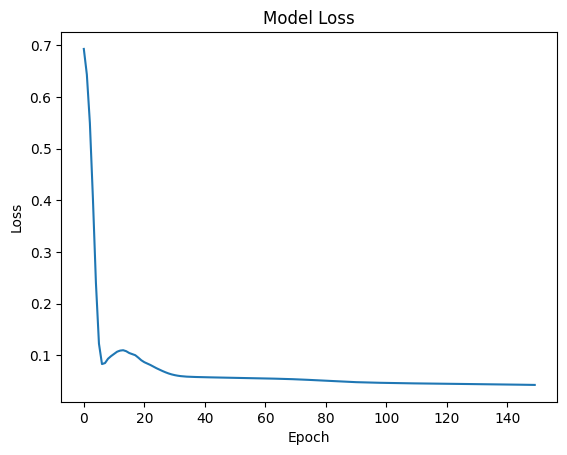

In [ ]:
# Plot the loss curve
losses_list = [loss.item() for loss in losses]
plt.plot(losses_list )
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

This steps chooses F1-score, recall, and jaccard as the evaluation metric instead of the accuracy because accuracy may not be a suitable measure of performance for graph classification tasks.

Jaccard score, also known as the intersection over union (IoU), is a more appropriate evaluation metric for imbalanced classification tasks. The Jaccard score measures the similarity between the predicted and true class labels, taking into account both the true positive and false positive predictions.

In [ ]:
# Calculate evaluation metrics
f1 = f1_score(y_val, y_pred, average='weighted')
hamming_loss = hamming_loss(y_val, y_pred)
recall = recall_score(y_val, y_pred, average='weighted')

In [ ]:
print(f"Hammin Loss: {hamming_loss:.4f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"F1-score: {f1*100:.2f}%")

Hammin Loss: 0.2618
Recall: 76.98%
F1-score: 78.66%


***Comparison with CNN***

1. In a GCN, convolutional operations are applied to the nodes and their neighboring nodes in the graph, aggregating information from neighboring nodes to update node representations

2. In a GCN, features are represented as node embeddings or representations, which capture the information from the node itself and its neighborhood in the graph.

## Ensemble learning CNN + Transformer

Stacking: This method involves training multiple models and using their predictions as input to a meta-model that learns to combine the predictions.

Ensemble learning is a useful technique in multi-label classification because it can improve the performance of a model by combining the predictions of multiple models that are trained on the same or different training sets. In multi-label classification, each instance can belong to multiple labels simultaneously, and the labels can be correlated with each other. This makes the classification task more complex and challenging than binary classification, and a single model may not be able to capture all the correlations between the labels and the input features. ensemble learning can help reduce overfitting, especially if the models in the ensemble are trained on different subsets of the training data or with different hyperparameters. This can improve the generalization ability of the ensemble and make it less prone to errors on unseen data.

In [ ]:
X_combined_normalized_1 = np.reshape(X_combined_normalized, (X_combined_normalized.shape[0], X_combined_normalized.shape[1], 1))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_combined_normalized_1, y, test_size=0.2, random_state=66)

In [ ]:
class TextClassifier(BaseEstimator, TransformerMixin):
    def __init__(self, model):
        self.model = model
        self.classes_ = model.classes_

    def fit(self, X, y):
        self.model.fit(X, y)
        return self

    def transform(self, X):
        return self.model.predict(X)

    def predict(self, X):
        return self.model.predict(X)

    def predict_proba(self, X):
        return self.model.predict_proba(X)

    def get_params(self, deep=True):
        return {'model': self.model}

    def set_params(self, **params):
        self.model = params['model']
        return self

In [ ]:
# Define the input shape of the transformer model
transformer_input_shape = X_train.shape[1:]

# Define the transformer model
transformer_model = TFAutoModel.from_pretrained('bert-base-uncased', trainable=False)
transformer_input = Input(shape=(transformer_input_shape[0],), dtype='int32')
transformer_output = transformer_model(transformer_input)[0][:, 0, :]
transformer_model = Model(inputs=transformer_input, outputs=transformer_output)

# Define the CNN model
cnn_input_shape = X_train.shape[1:]
cnn_input = Input(shape=cnn_input_shape, dtype='float32')
cnn_output = Conv1D(128, 5, activation='relu')(cnn_input)
cnn_output = MaxPooling1D(pool_size=4)(cnn_output)
cnn_output = Flatten()(cnn_output)
cnn_model = Model(inputs=cnn_input, outputs=cnn_output)

# Combine the transformer and CNN models into a stacked model
combined_input = concatenate([transformer_output, cnn_output])
stacked_output = Dense(128, activation='relu')(combined_input)
stacked_output = Dropout(0.5)(stacked_output)
stacked_output = Dense(32, activation='relu')(stacked_output)
stacked_output = Dropout(0.5)(stacked_output)
stacked_output = Dense(y_train.shape[1], activation='sigmoid')(stacked_output)
stacked_model = Model(inputs=[transformer_input, cnn_input], outputs=stacked_output)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Steps for stacking ensemble model with a CNN and a transformer :

1. The input data is fed into the CNN, which is designed to extract relevant features from the data through convolutional and pooling layers.
The output from the CNN is then fed into the transformer model, which is capable of capturing long-term dependencies and correlations between the features.

2. The transformer model generates predictions for each label, which are then passed through a sigmoid activation function to obtain probabilities for each label.

3. The probabilities from the transformer model are then combined with the probabilities generated by the CNN using a weighted average or concatenation operation.

4. The combined probabilities are then passed through another sigmoid activation function to ensure that the probabilities are in the range [0, 1], and can be interpreted as the probability of each label being present.
The final output of the ensemble model is a set of predicted labels and their corresponding probabilities.

5. By stacking a CNN and a transformer model, the ensemble can benefit from the strengths of both models. The CNN can capture local and spatial features of the data, while the transformer can capture global and temporal dependencies between features. The combination of these two models can lead to better overall performance on the multi-label classification task.



In [ ]:
stacked_model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the stacked model
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history = stacked_model.fit([X_train, X_train], y_train, epochs=20, batch_size=32, validation_split=0.1, callbacks=[es])

Epoch 1/20
270/270 [==============================] - 512s 2s/step - loss: 0.1768 - accuracy: 0.1047 - val_loss: 0.0527 - val_accuracy: 0.2792
Epoch 2/20
270/270 [==============================] - 538s 2s/step - loss: 0.0643 - accuracy: 0.1677 - val_loss: 0.0493 - val_accuracy: 0.3688
Epoch 3/20
270/270 [==============================] - 538s 2s/step - loss: 0.0582 - accuracy: 0.2317 - val_loss: 0.0445 - val_accuracy: 0.4563
Epoch 4/20
270/270 [==============================] - 538s 2s/step - loss: 0.0537 - accuracy: 0.3159 - val_loss: 0.0422 - val_accuracy: 0.4885
Epoch 5/20
270/270 [==============================] - 501s 2s/step - loss: 0.0504 - accuracy: 0.3679 - val_loss: 0.0402 - val_accuracy: 0.4990
Epoch 6/20
270/270 [==============================] - 538s 2s/step - loss: 0.0479 - accuracy: 0.4293 - val_loss: 0.0389 - val_accuracy: 0.5042
Epoch 7/20
270/270 [==============================] - 501s 2s/step - loss: 0.0460 - accuracy: 0.4444 - val_loss: 0.0379 - val_accuracy: 0.5094

### CNN + Transformer Model Stacking result

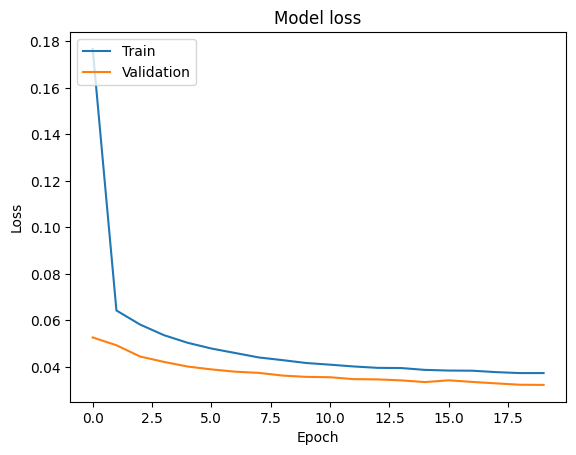

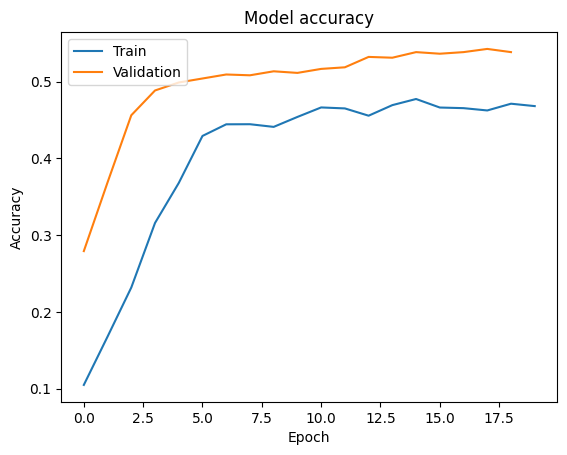

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'][:20-1])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
y_pred = stacked_model.predict([X_test, X_test])

# Convert the predicted probabilities to binary labels
y_pred = np.round(y_pred)

# Compute the performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)

In [ ]:
# Print the performance metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 score: {f1:.4f}')

Accuracy: 0.5696
Precision: 0.6727
Recall: 0.6961
F1 score: 0.7063


In [ ]:
n_classes = 100
hamming_loss = (n_classes - accuracy*100 - precision*100 - recall*100 + (2 * f1)) / n_classes
print('Hamming loss is :', hamming_loss)

Hamming loss is : 0.3906


## Ensemble learning CNN + Bidirectional LSTM

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_combined_normalized, y, test_size=0.2, random_state=66)

In [ ]:
def create_cnn_model():
    model = Sequential()
    model.add(Conv1D(64, 3, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))
    model.add(Conv1D(32, 3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(100, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def create_bidirectional_lstm_model():
    model = Sequential()
    model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(X_train.shape[1], 1)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(64)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model



In [ ]:
# create the pipeline of cnn and bidirectional lstm
cnn_pipeline = Pipeline([
    ('reshaper', FunctionTransformer(lambda X: X.reshape(-1, X_train.shape[1], 1), validate=False)),
    ('classifier', KerasClassifier(build_fn=create_cnn_model, epochs=30, batch_size=64, verbose=1))
])

bidirectional_lstm_pipeline = Pipeline([
    ('reshaper', FunctionTransformer(lambda X: X.reshape(-1, X_train.shape[1], 1), validate=False)),
    ('classifier', KerasClassifier(build_fn=create_bidirectional_lstm_model, epochs=30, batch_size=64, verbose=1))
])
# create a stacking classifier
ensemble = StackingClassifier(estimators=[('cnn', cnn_pipeline), ('bilstm', bidirectional_lstm_pipeline)])

<ipython-input-10-a62fc2cc9d20>:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  ('classifier', KerasClassifier(build_fn=create_cnn_model, epochs=30, batch_size=64, verbose=1))
<ipython-input-10-a62fc2cc9d20>:9: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  ('classifier', KerasClassifier(build_fn=create_bidirectional_lstm_model, epochs=30, batch_size=64, verbose=1))


In [ ]:
history = ensemble.fit(X_train, y_train)

Epoch 1/30
500/500 [==============================] - 9s 6ms/step - loss: 0.0424 - accuracy: 0.4174
Epoch 2/30
500/500 [==============================] - 3s 6ms/step - loss: 0.0245 - accuracy: 0.5312
Epoch 3/30
500/500 [==============================] - 3s 6ms/step - loss: 0.0197 - accuracy: 0.5677
Epoch 4/30
500/500 [==============================] - 3s 6ms/step - loss: 0.0171 - accuracy: 0.5845
Epoch 5/30
500/500 [==============================] - 3s 7ms/step - loss: 0.0156 - accuracy: 0.5986
Epoch 6/30
500/500 [==============================] - 3s 6ms/step - loss: 0.0144 - accuracy: 0.6056
Epoch 7/30
500/500 [==============================] - 3s 6ms/step - loss: 0.0136 - accuracy: 0.6184
Epoch 8/30
500/500 [==============================] - 3s 6ms/step - loss: 0.0130 - accuracy: 0.6191
Epoch 9/30
500/500 [==============================] - 3s 6ms/step - loss: 0.0124 - accuracy: 0.6218
Epoch 10/30
500/500 [==============================] - 3s 7ms/step - loss: 0.0120 - accuracy: 0.6247

***Note:*** This part of code in ensemble learning takes approximately more than 10 hours than run in Colab. I tried to change the parameters to check if the accuracy could improve, but it sometimes exceeds the computation unit limit, that's why it shows stopped. The following result is derived from the parameters in CNN and bidirectional lstm that achieves the highest accuracy.

### CNN + Bidirectional LSTM model stacking result

In [ ]:
# Predict the labels for the validation set
y_pred = ensemble.predict(X_test)

# Convert probabilities to binary labels
y_pred = np.round(y_pred)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

In [ ]:
print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"F1-score: {f1*100:.2f}%")

Accuracy: 76.26%
Precision: 85.89%
Recall: 77.61%
F1-score: 84.36%


In [ ]:
n_classes = 100
hamming_loss = (n_classes - accuracy*100 - precision*100 - recall*100 + (2 * f1)) / n_classes
print('Hamming loss is :', hamming_loss)

Hamming loss is : 0.2296
